# Popularity analysis of Linux distributions

## Contents
1. [Installing Dependencies](#installing-dependencies)
1. [Scraping Data](#scraping-data)
1. [Loading Data](#loading-data)
1. [Most Popular Distros](#most-popular-distros)
1. [Geographical Data](#geo)
1. [Linear Regression](#linear-regression)
1. [ARIMA](#arima)
1. [SARIMAX](#sarimax)
1. [Correlation Between Desktop Environment and Popularity](#correlation-between-desktop-environment-and-popularity)
1. [K-Means Clustering](#k-means-clustering)
1. [Principal Component Analysis](#principal-component-analysis)
1. [Random Forest Regression](#random-forest-regression)

## Installing Dependencies

In [ ]:
! pip install selenium bs4 pandas matplotlib seaborn geopandas scikit-learn scipy statsmodels

## Scraping Data

In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time
import pandas as pd
from datetime import date
import os

def run_scraper():
    data_path = './data/'

    # Get current date in ISO format
    current_date = date.today().isoformat()

    # Set up headless browser
    options = Options()
    options.headless = True  # Run Chrome in headless mode (no GUI)
    options.add_argument('--headless')  # Ensure it's in headless mode
    options.add_argument('--disable-gpu')  # Disable GPU hardware acceleration
    options.add_argument('--no-sandbox')  # Disable the sandbox (helpful for Windows)
    options.add_argument('--disable-dev-shm-usage')  # Use /tmp for shared memory
    driver = webdriver.Chrome(options=options)

    # Open the URL
    url = "https://distrowatch.com/dwres.php?resource=popularity"
    driver.get(url)

    # Wait for the page to load (you may need to adjust this for your use case)
    driver.implicitly_wait(5)

    # Get page source after JavaScript is rendered
    html = driver.page_source

    # Parse the page source with BeautifulSoup
    soup = BeautifulSoup(html, 'html.parser')
    title = soup.title.string if soup.title else 'No title'
    print(f'Title of the page: {title}')

    # Create a set to store unique names
    unique_names = set()
    distro_names_file = data_path + 'distro_names.csv'

    # Check if the CSV file exists
    if os.path.exists(distro_names_file):
        # If it exists, read the CSV into a DataFrame
        distro_names = pd.read_csv(distro_names_file, index_col=0)
    else:
        # If it does not exist, create a new DataFrame with the specified columns
        distro_names = pd.DataFrame(columns=['full_name', 'short_name'])

    # Find all <td> elements with class 'phr2'
    td_elements_phr2 = soup.find_all('td', class_='phr2')

    # Check if we found any <td> with class 'phr2'
    if td_elements_phr2:
        # Iterate through all <td> elements with class 'phr2'
        for td_element in td_elements_phr2:
            # Find all <a> tags within the current <td> element
            links = td_element.find_all('a')
            for link in links:
                unique_names.add(link['href'])
                #print(f"Link text: {link.get_text()}, URL: {link['href']}")
                distro_names.loc[len(distro_names)] = [link.get_text(), link['href']]
    else:
        print("No <td> elements with class 'phr2' found.")

    print(unique_names)
    distro_names.drop_duplicates().to_csv(distro_names_file)


    column_names = ['Distro', 'OS Type', 'Based On', 'Origin', 'Architecture', 'Desktop', 
                    'Category', 'Status', 'Popularity']

    df = pd.DataFrame(columns=column_names)

    # Function to visit each link and perform actions (like scraping)
    def visit_links(links):
        for link in links:
            try:
                print(f"Visiting: {link}")
                driver.get(link)  # Navigate to the link
                # Wait for page to load completely
                WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, "body")))
                
                page_title = driver.title
                print(f"Page title: {page_title}")
                
                html = driver.page_source

                # Parse the HTML
                soup = BeautifulSoup(html, 'html.parser')

                li_elements = soup.select('body > table > tbody > tr > td > table > tbody > tr > td > ul > li')
    
                extracted_data = [li.text.split(":")[1].strip() if ":" in li.text else li.text for li in li_elements]

                final_data = extracted_data[:8]
                distro_name = link.split("=")[1] 
                final_data.insert(0, distro_name)

                print(final_data)
                df.loc[len(df)] = final_data

                time.sleep(15)

            except Exception as e:
                print(f"Error visiting {link}: {e}")

        df.to_csv("distros_" + current_date + ".csv")


    def getURL(name):
        return "https://cumulative.com/table.php?distribution=" + name


    def generateURLs():
        urls = list()
        for un in unique_names:
            urls.append(getURL(un))
        return urls


    # Visit all the links
    visit_links(generateURLs())

    # Close the browser
    driver.quit()

In [3]:
# Uncomment the line below to run the scraper
#run_scraper()

## Loading data

In [4]:
data_path = './data/'
cumulative_data_path = data_path + 'cumulative/'

file_list = ['cumulative_2024-12-11.csv',
             'cumulative_2024-12-12.csv',
             'cumulative_2024-12-13.csv',
             'cumulative_2024-12-14.csv',
             'cumulative_2024-12-15.csv',
             'cumulative_2024-12-16.csv',
             'cumulative_2024-12-17.csv',
             'cumulative_2024-12-18.csv',
             'cumulative_2024-12-19.csv',
             'cumulative_2024-12-20.csv',
             'cumulative_2024-12-21.csv',
             'cumulative_2024-12-22.csv',
             'cumulative_2024-12-23.csv',
             'cumulative_2024-12-24.csv',
             'cumulative_2024-12-25.csv',
             'cumulative_2024-12-26.csv',
             'cumulative_2024-12-27.csv',
             'cumulative_2024-12-28.csv',
             'cumulative_2024-12-29.csv',
             'cumulative_2024-12-30.csv',
             'cumulative_2024-12-31.csv',
             'cumulative_2025-01-01.csv',
             'cumulative_2025-01-02.csv',
             'cumulative_2025-01-03.csv',
             'cumulative_2025-01-04.csv',
             'cumulative_2025-01-05.csv',
             'cumulative_2025-01-06.csv',
             'cumulative_2025-01-07.csv',
             'cumulative_2025-01-08.csv',
             'cumulative_2025-01-09.csv',
             'cumulative_2025-01-10.csv',
             'cumulative_2025-01-11.csv',
             'cumulative_2025-01-12.csv',
             'cumulative_2025-01-13.csv',
             'cumulative_2025-01-14.csv',
             'cumulative_2025-01-15.csv']

dfs = list()

columns = [
    'rank_12m', 'distro_12m', 'hpd_12m',
    'rank_6m', 'distro_6m', 'hpd_6m',
    'rank_3m', 'distro_3m', 'hpd_3m',
    'rank_1m', 'distro_1m', 'hpd_1m'
]

for file in file_list:
    df = pd.read_csv(cumulative_data_path + file, skiprows=0, dtype={'rank_12m': int, 'distro_12m': str, 'hpd_12m': int, 'rank_6m': int, 'distro_6m': str, 'hpd_6m': int, 'rank_3m': int, 'distro_3m': str, 'hpd_3m': int, 'rank_1m': int, 'distro_1m': str, 'hpd_1m': int})

    # Set the column names in the existing DataFrame
    df.columns = columns

    # Create a new DataFrame with the desired structure
    reshaped_df = pd.DataFrame({
        'distro_name': df['distro_12m'], # Take the distro name from the 12m column
        'rank_12m': df['rank_12m'],
        'hpd_12m': df['hpd_12m'],
        'rank_6m': df['rank_6m'],
        'hpd_6m': df['hpd_6m'],
        'rank_3m': df['rank_3m'],
        'hpd_3m': df['hpd_3m'],
        'rank_1m': df['rank_1m'],
        'hpd_1m': df['hpd_1m'],
    })

    dfs.append(reshaped_df)

In [5]:
# Load data containing details about each distro
df_distros = pd.read_csv(data_path + 'distros_2024-12-21.csv', index_col=0)

## Most Popular Distros

Here we visualize the top 50 Linux distributions in terms of their hits per day, displaying them in a bar chart. This helps to easily compare the popularity of different distributions based on their HPD values.

Text(0, 0.5, 'hits per day')

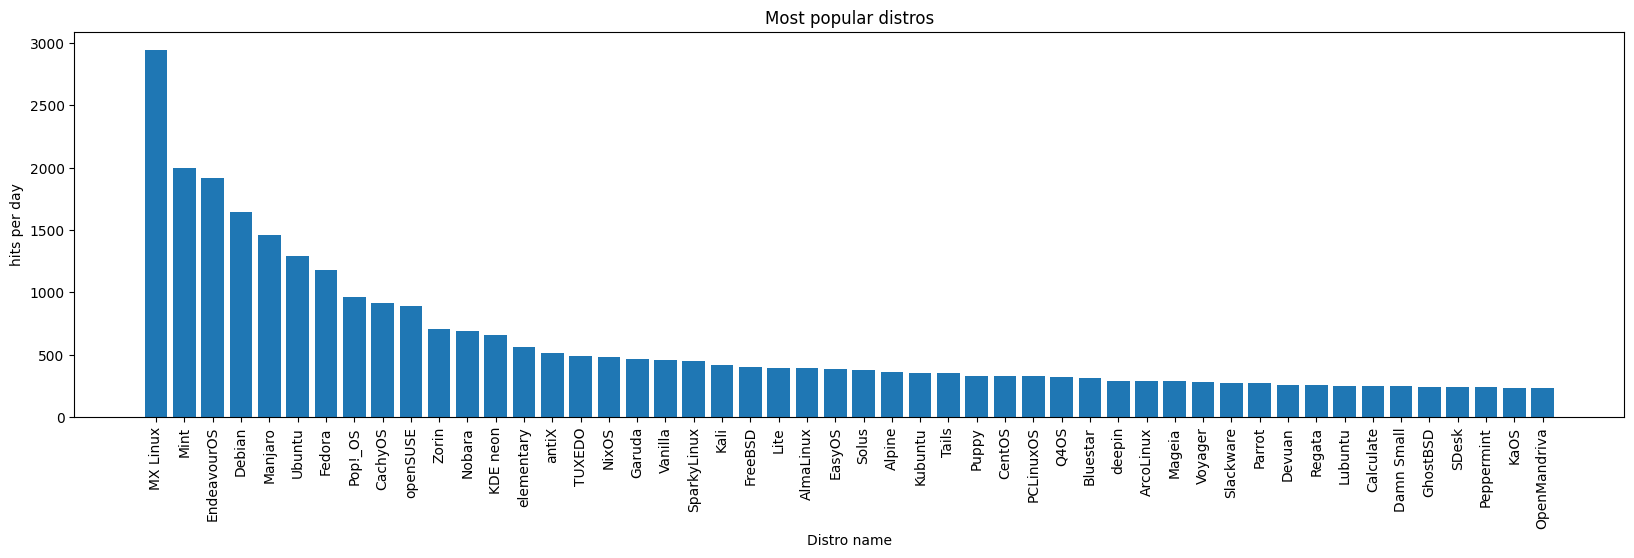

In [6]:
import matplotlib.pyplot as plt

df_subset = dfs[-1].head(50)  # Get the first 50 rows of the last DataFrame in the list
plt.figure(figsize=(20, 5))
plt.bar(df_subset['distro_name'], df_subset['hpd_1m'])
plt.xticks(rotation=90)
plt.title('Most popular distros')
plt.xlabel('Distro name')
plt.ylabel('hits per day')

## Geographical Data

Here we count how many Linux distributions originate from each country and prepare the data for use in maps by standardizing country names (e.g., renaming "USA" to "United States of America"). Then we display the top 25 countries based on the number of distributions.

In [7]:
country_counts = df_distros['Origin'].value_counts()
# Convert the series into a DataFrame
country_counts_df = country_counts.reset_index()

# Rename the columns for better readability
country_counts_df.columns = ['Origin', 'Count']

# Rename 'USA' to 'United States of America' so it can be merged with natural earth data and shown on map
usa_count = country_counts_df.loc[country_counts_df['Origin'] == 'USA']['Count']
country_counts_df.loc[country_counts_df['Origin'] == 'USA'] = ['United States of America', usa_count[0]]

print(country_counts_df.head(25))

                      Origin  Count
0   United States of America     64
1                     France     21
2                    Germany     17
3                     Global     16
4                      Italy     13
5             United Kingdom     12
6                      Spain     10
7                     Canada     10
8                Switzerland      7
9                    Ireland      6
10                    Poland      6
11                     Japan      6
12                    Russia      6
13               Netherlands      6
14                     India      5
15                     China      5
16                 Australia      5
17                    Brazil      5
18               Isle of Man      4
19                   Austria      3
20                    Turkey      3
21                    Norway      3
22            Czech Republic      2
23                    Sweden      2
24                    Taiwan      2


Here we are converting the data from column *Popularity*, which contains numbers and text, to a numerical value called *numerical_popularity*.

In [8]:
# Function to extract number before first space
def extract_number(text):
    space_pos = text.find(' ')
    return int(text[:space_pos] if space_pos != -1 else text)  # Handle case where no space is found

# Apply the function to the column
df_distros['numerical_popularity'] = df_distros['Popularity'].apply(extract_number)

Here we are plotting the data onto a map from [Natural Earth](https://www.naturalearthdata.com/).

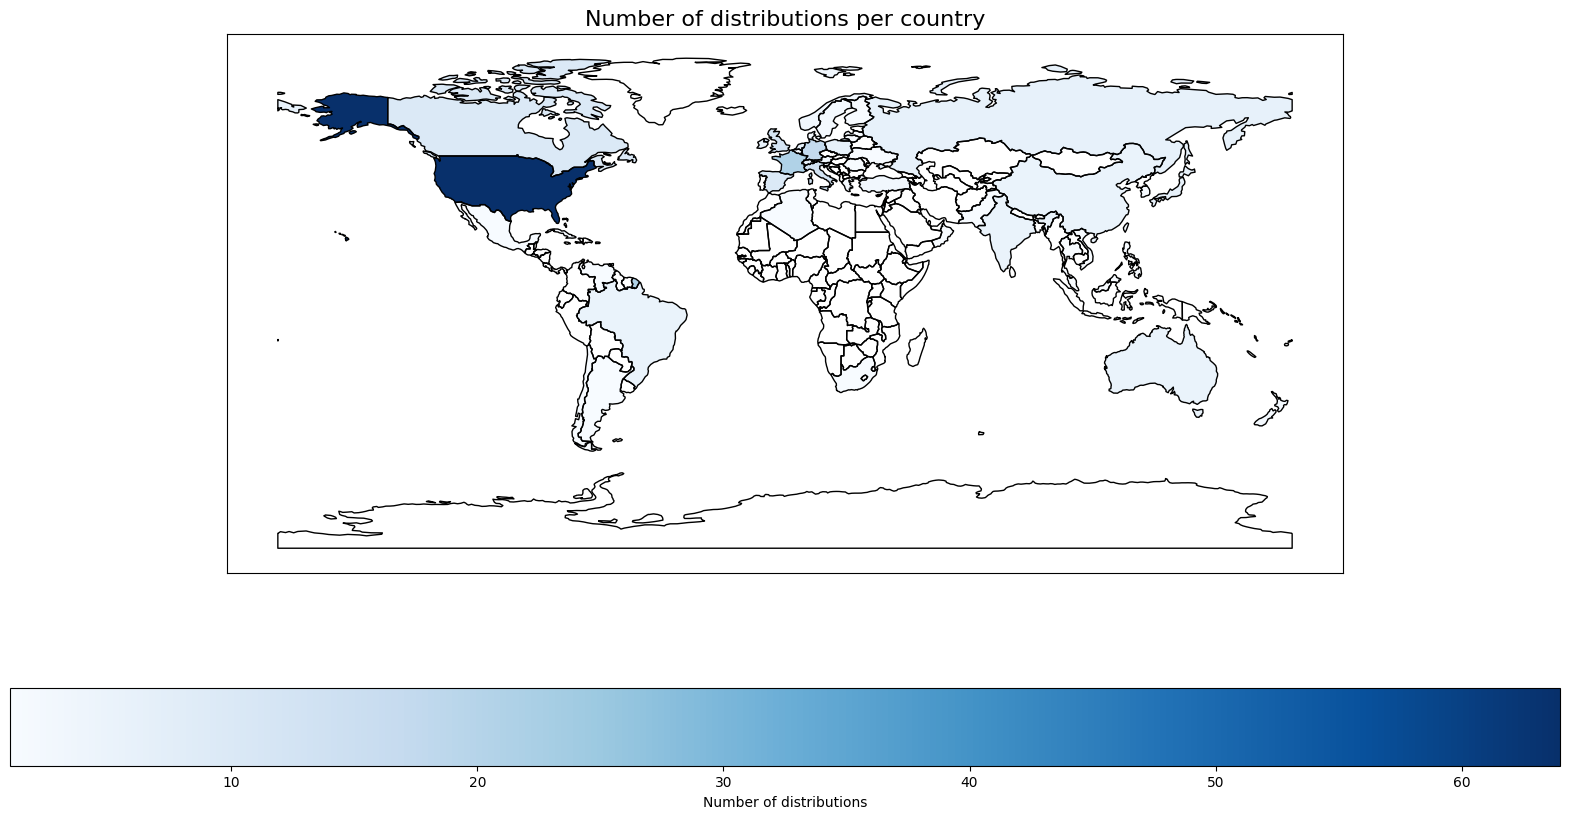

In [9]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

# Load the low resolution world map
world = gpd.read_file('./ne/ne_110m_admin_0_countries.shp')

world = world.merge(country_counts_df, left_on='ADMIN', right_on='Origin', how='left')

# Initialize an empty figure and add an axis
fig, ax = plt.subplots(figsize=(20, 10))

world.boundary.plot(ax=ax, linewidth=1, color='black')  # Add country boundaries

world.plot(
    ax=ax,
    column='Count',
    cmap='Blues',
    legend=True,
    legend_kwds={'label': "Number of distributions", 'orientation': "horizontal"},
    alpha=1
)

# Turn off axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Set the plot title
plt.title("Number of distributions per country", fontsize=16)
plt.show()


## Linear Regression

Here we implement a linear regression model to predict the number of hits per day (HPD) for a specific Linux distribution over time, based on historical data. We also calculate the error between the predicted value and the actual value for the last available data point.

In [10]:
from sklearn.linear_model import LinearRegression
from datetime import date, timedelta, datetime

first_date = datetime(2024, 12, 11)

def linear_regression(distro):
    full_df = pd.DataFrame(columns=['date', 'hpd'])
    for i, df in enumerate(dfs):
        row = df[df['distro_name'] == distro]
        full_df.loc[len(full_df)] = [first_date + timedelta(days=i), row['hpd_1m'].iloc[0]]
    
    data_to_fit = full_df[:-1].copy()  # Exclude the last row
    last_row = full_df[-1:].copy()  # Get the last row

    # Calculate the variance of the 'hpd' values
    variance_hpd = data_to_fit['hpd'].var()
    print(f"Variance of HPD: {variance_hpd}")

    # Initial data
    plt.scatter(full_df['date'], full_df['hpd'])
    plt.title(distro)
    plt.xticks(rotation=90)
    plt.xlabel('date')
    plt.ylabel('hits per day')

    # Convert date to numeric format
    data_to_fit['date'] = pd.to_datetime(data_to_fit['date'], errors='coerce')  
    data_to_fit['date_numeric'] = (data_to_fit['date'] - data_to_fit['date'].min()).dt.days
    
    # Fit the model to data
    model = LinearRegression()
    model.fit(data_to_fit[['date_numeric']], data_to_fit['hpd'])
    predictions = model.predict(data_to_fit[['date_numeric']])
    plt.plot(data_to_fit['date'], predictions, label='Linear Regression', color='red', linestyle='--')

    # Convert future date to numeric format
    future_date = last_row['date'].iloc[0]
    future_date = pd.to_datetime(future_date, errors='coerce')  
    future_date_numeric = (future_date - data_to_fit['date'].min()).days 
    df_future_date = pd.DataFrame({
    'date_numeric': [future_date_numeric]  # Add the numeric date as a column
    })

    # Predicting hpd for a future date
    future_hpd = model.predict(df_future_date)

    # Plot the prediction
    plt.scatter(future_date, future_hpd, color='green', label=f'Prediction for {future_date.strftime("%Y-%m-%d")}')
    print('Prediction for ' + future_date.isoformat() + ' is: ' + str(future_hpd[0]))
    print('Actual HPD for: ' + future_date.isoformat() + ' is:' + str(last_row['hpd'].iloc[0]))
    print('Error: ' + str(abs(future_hpd[0] - last_row['hpd'].iloc[0])))
    print('Error percentage: ' + str(abs(future_hpd[0] - last_row['hpd'].iloc[0]) / last_row['hpd'].iloc[0] * 100) + '%')

Variance of HPD: 2021.3647058823528
Prediction for 2025-01-15T00:00:00 is: 1254.5142857142857
Actual HPD for: 2025-01-15T00:00:00 is:1181
Error: 73.51428571428573
Error percentage: 6.22474900205637%


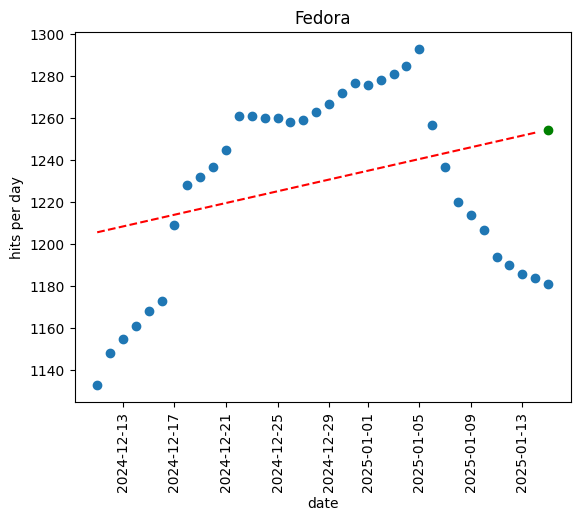

In [11]:
linear_regression('Fedora')

Variance of HPD: 2137.717647058824
Prediction for 2025-01-15T00:00:00 is: 846.6974789915967
Actual HPD for: 2025-01-15T00:00:00 is:887
Error: 40.302521008403346
Error percentage: 4.543688952469374%


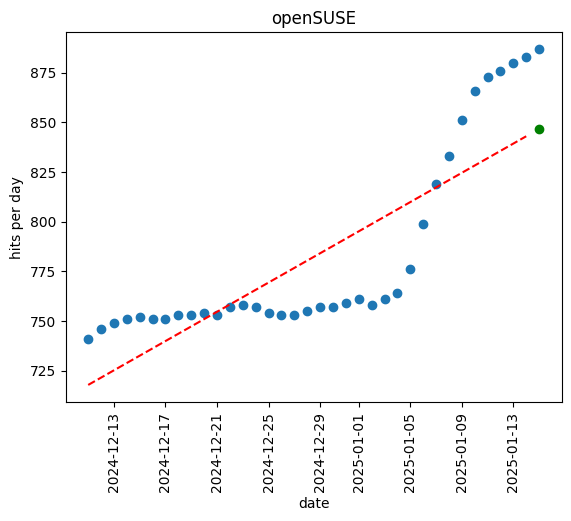

In [12]:
linear_regression('openSUSE')

Variance of HPD: 106.67563025210086
Prediction for 2025-01-15T00:00:00 is: 214.69915966386554
Actual HPD for: 2025-01-15T00:00:00 is:217
Error: 2.3008403361344563
Error percentage: 1.0602950857762472%


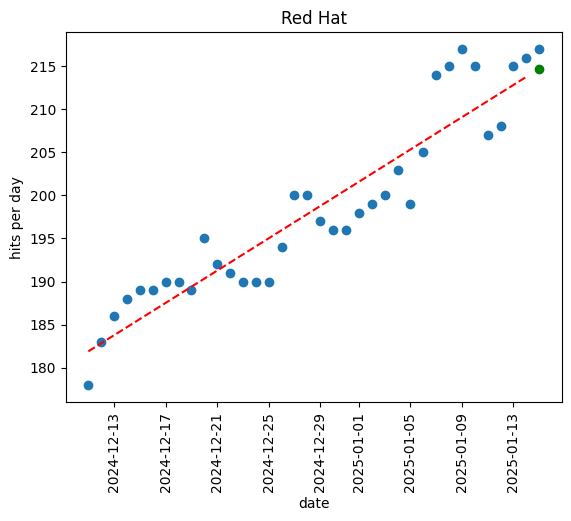

In [13]:
linear_regression('Red Hat')

## ARIMA

Here we perform time series analysis on the popularity of a specific Linux distribution (identified by *distro_name*) using the ARIMA (AutoRegressive Integrated Moving Average) model. The process includes data preparation, stationarity testing, ARIMA model fitting, forecasting, and performance evaluation. 

In [14]:
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller  # To check stationarity
from sklearn.metrics import mean_squared_error

def run_arima(distro_name):
    first_date = datetime(2024, 12, 11)

    # Create an empty DataFrame to store the data for time series analysis
    arima_data = pd.DataFrame(columns=['date', 'hpd'])

    # Loop through each DataFrame in dfs to extract 'hpd_1m' for the given distro
    for i, df in enumerate(dfs):
        row = df[df['distro_name'] == distro_name]
        # Add a new row with date and the 'hpd_1m' value for the selected distro
        arima_data.loc[len(arima_data)] = [first_date + timedelta(days=i), row['hpd_1m'].iloc[0]]

    # Convert the 'date' column to datetime
    arima_data['date'] = pd.to_datetime(arima_data['date'])

    # Set the 'date' column as the index of the DataFrame
    arima_data.set_index('date', inplace=True)

    # Explicitly set the frequency to daily (D) for the datetime index
    arima_data.index = pd.DatetimeIndex(arima_data.index, freq='D')

    # Now, 'arima_data' should have the correct date index and 'hpd' values.
    # Plot the time series
    plt.figure(figsize=(10, 6))
    plt.plot(arima_data['hpd'])
    plt.title(f'Time Series of {distro_name} Popularity')
    plt.xlabel('Date')
    plt.ylabel('Popularity')
    plt.xticks(rotation=90)
    plt.show()

    # Check for stationarity using the Augmented Dickey-Fuller test
    adf_result = adfuller(arima_data['hpd'].dropna())  # Drop NA values for the test
    print(f'ADF Statistic: {adf_result[0]}')
    print(f'p-value: {adf_result[1]}')

    # If p-value > 0.05, the series is non-stationary, and we need differencing

    # Check if the series is stationary or not
    if adf_result[1] > 0.05:
        print("The series is non-stationary. Differencing will be applied.")
        # Apply differencing if necessary (d=1 for first difference)
        arima_data['hpd_diff'] = arima_data['hpd'].diff().dropna()

        # Replot the differenced series
        plt.figure(figsize=(10, 6))
        plt.plot(arima_data['hpd_diff'])
        plt.title(f'Differenced Time Series of {distro_name} Popularity')
        plt.xlabel('Date')
        plt.ylabel('Popularity (Differenced)')
        plt.xticks(rotation=90)
        plt.show()
    else:
        print("The series is stationary. No differencing needed.")

    train_size = int(0.9 * len(arima_data))
    train_data = arima_data['hpd'][:train_size]
    test_data = arima_data['hpd'][train_size:]

    # ARIMA Model fitting
    # We choose (p, d, q) parameters. Here we use (1, 1, 1) for simplicity
    arima_model = ARIMA(train_data, 
                        order=(1, 1, 1))  # Non-seasonal order (p, d, q)

    # Fit the model
    arima_model_fit = arima_model.fit()

    # Print the summary of the fitted model
    print(arima_model_fit.summary())

    # Forecast future values
    arima_forecast = arima_model_fit.forecast(steps=len(test_data))
    print(f"Forecast for {distro_name}:")
    print(arima_forecast)

    # Evaluate the model performance using Mean Squared Error
    mse = mean_squared_error(test_data, arima_forecast)
    print(f'Mean Squared Error: {mse}')

    # Plot the original data and forecasted values
    plt.figure(figsize=(10, 6))
    plt.plot(arima_data['hpd'], label='Original Data')
    plt.plot(test_data.index, arima_forecast, label='Forecast', color='red')
    plt.title(f"Forecast for {distro_name} Popularity")
    plt.xlabel('Date')
    plt.ylabel('Popularity')
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()

    residuals = arima_model_fit.resid
    plt.figure(figsize=(10, 6))
    plt.plot(residuals)
    plt.title('Residuals of the ARIMA Model')
    plt.xticks(rotation=90)
    plt.show()


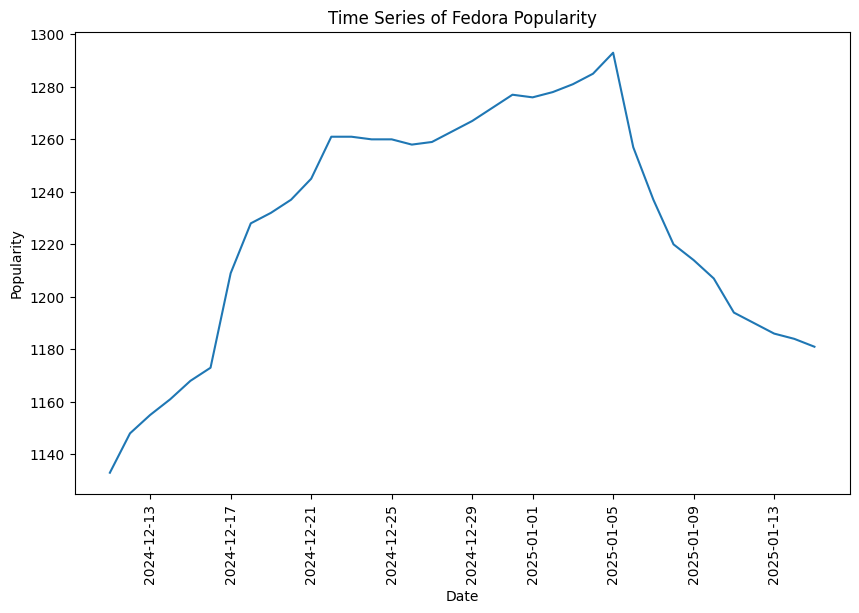

ADF Statistic: -1.6048688763289705
p-value: 0.4811472517284226
The series is non-stationary. Differencing will be applied.


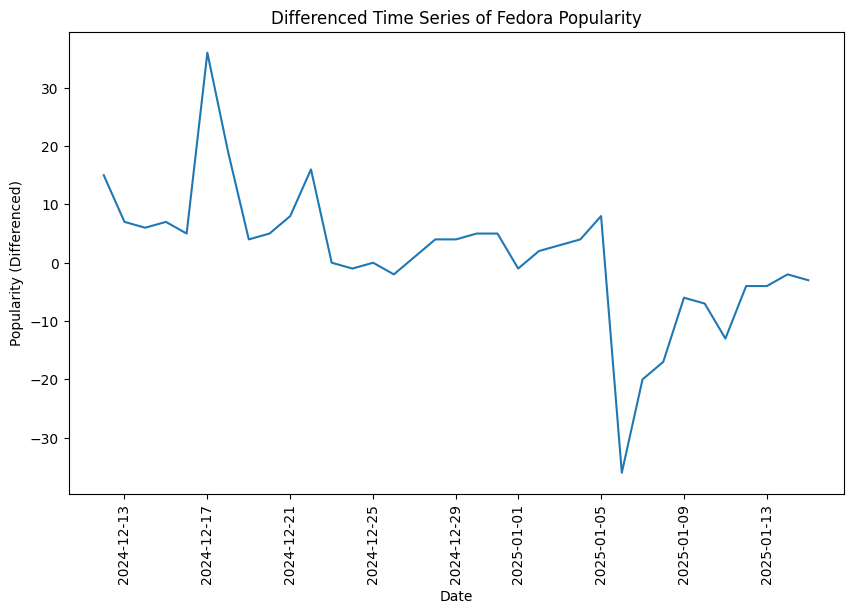

                               SARIMAX Results                                
Dep. Variable:                    hpd   No. Observations:                   32
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -116.971
Date:                Wed, 15 Jan 2025   AIC                            239.941
Time:                        23:21:53   BIC                            244.243
Sample:                    12-11-2024   HQIC                           241.343
                         - 01-11-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7973      0.317      2.513      0.012       0.175       1.419
ma.L1         -0.3970      0.573     -0.693      0.488      -1.519       0.725
sigma2       109.4686     16.074      6.810      0.0

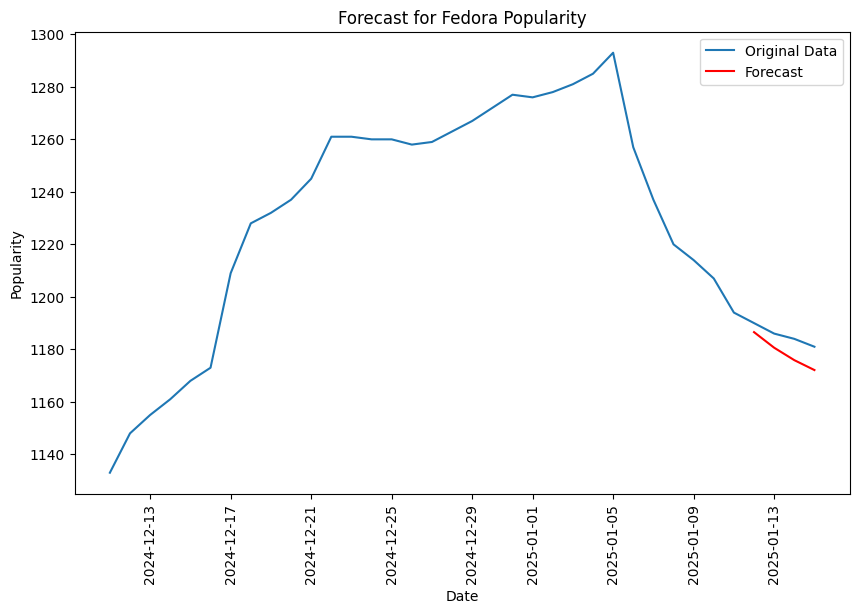

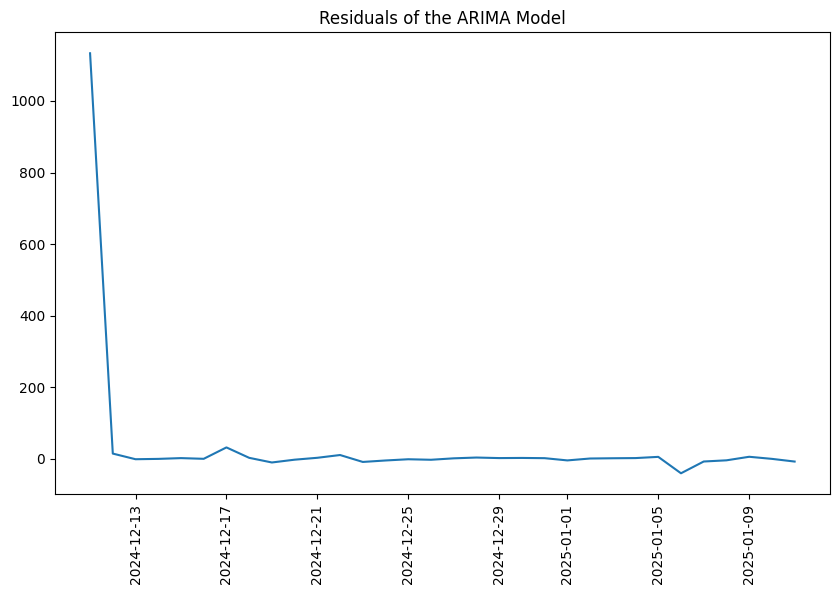

In [15]:
run_arima('Fedora')

## SARIMAX

Here we apply SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) modeling for forecasting the popularity (hits per day) of a given Linux distribution over time, including seasonal components and evaluating the model's accuracy.

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller  # To check stationarity

def run_sarimax(distro_name):
    first_date = datetime(2024, 12, 11)

    # Create an empty DataFrame to store the data for time series analysis
    sarimax_data = pd.DataFrame(columns=['date', 'hpd'])

    # Loop through each DataFrame in dfs to extract 'hpd_1m' for the given distro
    for i, df in enumerate(dfs):
        row = df[df['distro_name'] == distro_name]
        # Add a new row with date and the 'hpd_1m' value for the selected distro
        sarimax_data.loc[len(sarimax_data)] = [first_date + timedelta(days=i), row['hpd_1m'].iloc[0]]

    # Convert the 'date' column to datetime
    sarimax_data['date'] = pd.to_datetime(sarimax_data['date'])

    # Set the 'date' column as the index of the DataFrame
    sarimax_data.set_index('date', inplace=True)

    # Explicitly set the frequency to daily (D) for the datetime index
    sarimax_data.index = pd.DatetimeIndex(sarimax_data.index, freq='D')

    # Now, 'sarimax_data' should have the correct date index and 'hpd' values.
    # Plot the time series
    plt.figure(figsize=(10, 6))
    plt.plot(sarimax_data['hpd'])
    plt.title(f'Time Series of {distro_name} Popularity')
    plt.xlabel('Date')
    plt.ylabel('Popularity')
    plt.xticks(rotation=90)
    plt.show()

    # Check for stationarity using the Augmented Dickey-Fuller test
    adf_result = adfuller(sarimax_data['hpd'].dropna())  # Drop NA values for the test
    print(f'ADF Statistic: {adf_result[0]}')
    print(f'p-value: {adf_result[1]}')

    # Check if the series is stationary or not
    if adf_result[1] > 0.05:
        print("The series is non-stationary. Differencing will be applied.")
        # Apply differencing if necessary (d=1 for first difference)
        sarimax_data['hpd_diff'] = sarimax_data['hpd'].diff().dropna()

        # Replot the differenced series
        plt.figure(figsize=(10, 6))
        plt.plot(sarimax_data['hpd_diff'])
        plt.title(f'Differenced Time Series of {distro_name} Popularity')
        plt.xlabel('Date')
        plt.ylabel('Popularity (Differenced)')
        plt.xticks(rotation=90)
        plt.show()
    else:
        print("The series is stationary. No differencing needed.")

    train_size = int(0.9 * len(sarimax_data))
    train_data = sarimax_data['hpd'][:train_size]
    test_data = sarimax_data['hpd'][train_size:]

    # SARIMA Model fitting
    # We choose (p, d, q) and (P, D, Q) parameters.
    sarimax_model = SARIMAX(train_data, 
                    order=(1, 1, 1),  # Non-seasonal order (p, d, q)
                    seasonal_order=(1, 1, 1, 12),  # Seasonal order (P, D, Q, s)
                    enforce_stationarity=False,  # Don't enforce stationarity constraints
                    enforce_invertibility=False)  # Don't enforce invertibility constraints

    # Fit the model
    sarimax_model_fit = sarimax_model.fit(disp=False)

    # Print the summary of the fitted model
    print(sarimax_model_fit.summary())

    # Forecast future values
    sarimax_forecast = sarimax_model_fit.forecast(steps=len(test_data))
    print(f"Forecast for {distro_name}:")
    print(sarimax_forecast)

    # Evaluate the model performance using Mean Squared Error
    mse = mean_squared_error(test_data, sarimax_forecast)
    print(f'Mean Squared Error: {mse}')

    # Plot the original data and forecasted values
    plt.figure(figsize=(10, 6))
    plt.plot(sarimax_data['hpd'], label='Original Data')
    plt.plot(test_data.index, sarimax_forecast, label='Forecast', color='red')
    plt.title(f"Forecast for {distro_name} Popularity")
    plt.xlabel('Date')
    plt.ylabel('Popularity')
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()

    residuals = sarimax_model_fit.resid
    plt.figure(figsize=(10, 6))
    plt.plot(residuals)
    plt.title('Residuals of the SARIMAX Model')
    plt.xticks(rotation=90)
    plt.show()

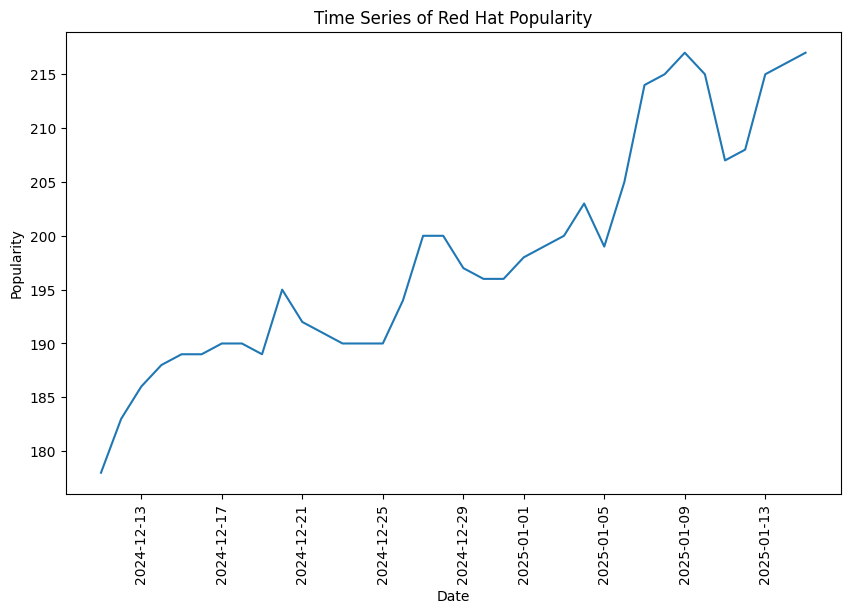

ADF Statistic: 1.7877953993551932
p-value: 0.9983245015298452
The series is non-stationary. Differencing will be applied.


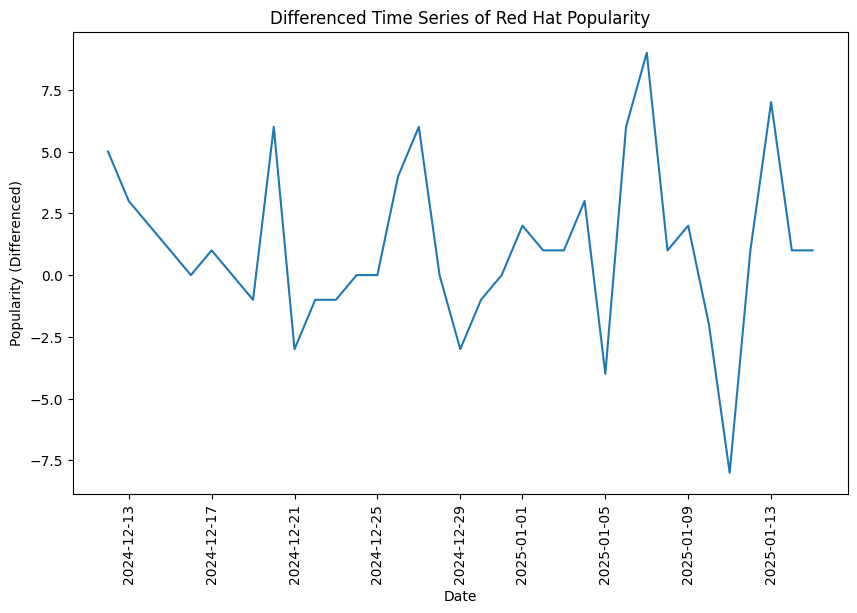

                                     SARIMAX Results                                      
Dep. Variable:                                hpd   No. Observations:                   32
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -14.096
Date:                            Wed, 15 Jan 2025   AIC                             38.192
Time:                                    23:21:53   BIC                             36.239
Sample:                                12-11-2024   HQIC                            32.951
                                     - 01-11-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3642      3.316      0.110      0.913      -6.135       6.864
ma.L1         -1.0001   8314.362   

C:\Users\Amadeo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


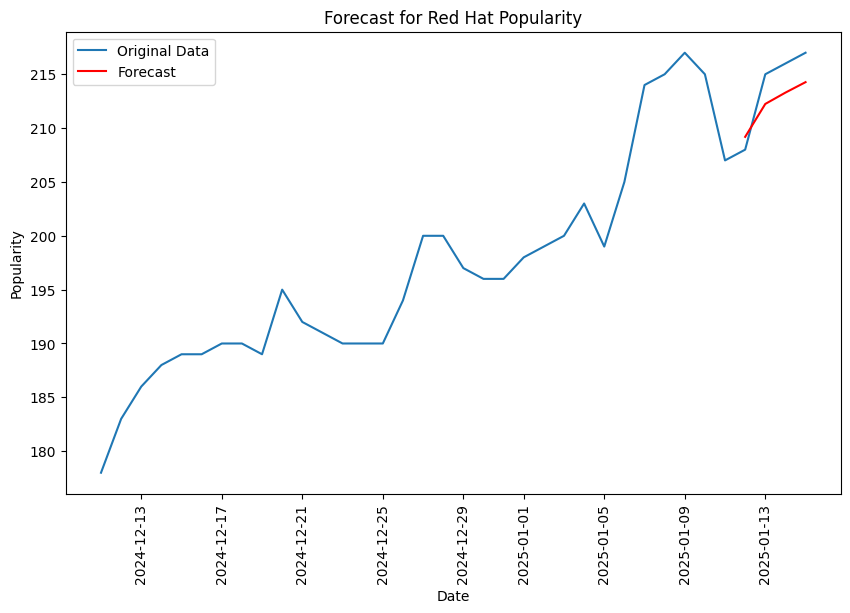

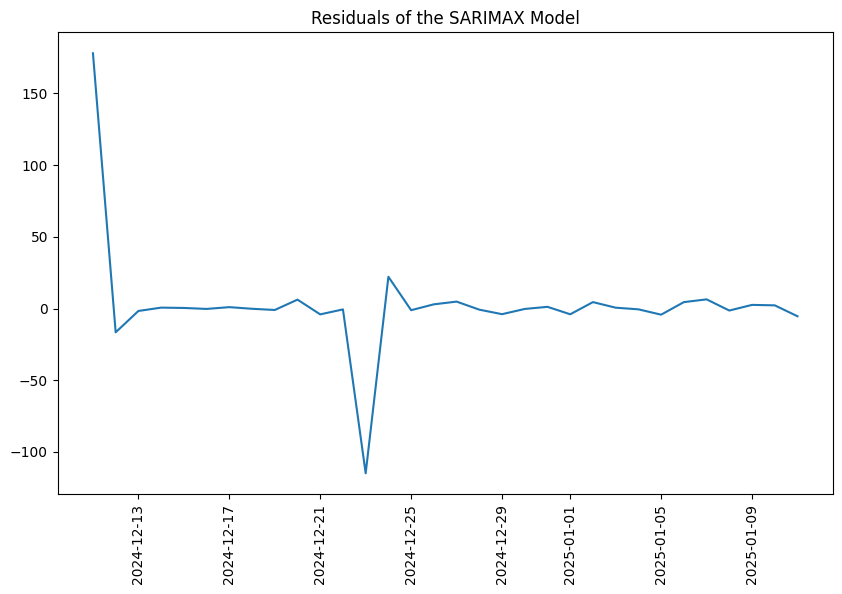

In [17]:
run_sarimax('Red Hat')

## Correlation between desktop environment and popularity

The *Desktop* column contains multiple values in a single field separated by a comma. We will split those values and expand the DataFrame to multiple rows.

In [18]:
# Split 'Desktop' column by commas and expand the DataFrame to multiple rows
df_split = df_distros.set_index(['Distro', 'numerical_popularity'])['Desktop'].str.split(', ', expand=True).stack().reset_index(name='Desktop')

# Now each distro has a separate row for each desktop environment
df_split = df_split[['Distro', 'Desktop', 'numerical_popularity']]

print(df_split)

           Distro        Desktop  numerical_popularity
0       eurolinux          GNOME                   111
1       eurolinux     KDE Plasma                   111
2           zorin          GNOME                    11
3           zorin           Xfce                    11
4     ufficiozero       Cinnamon                   118
..            ...            ...                   ...
701  postmarketos          Phosh                   144
702  postmarketos  Plasma Mobile                   144
703  postmarketos           Sxmo                   144
704       ferenos       Cinnamon                   169
705       ferenos     KDE Plasma                   169

[706 rows x 3 columns]


Now we can calculate the correlation.

In [19]:
from sklearn.preprocessing import LabelEncoder

# Label encode the 'Desktop' column
label_encoder = LabelEncoder()
df_split['Desktop_encoded'] = label_encoder.fit_transform(df_split['Desktop'])

# Now calculate the correlation
correlation = df_split['Desktop_encoded'].corr(df_split['numerical_popularity'])
print(f"Correlation between Desktop Environment and Popularity: {correlation}")


Correlation between Desktop Environment and Popularity: 0.07422045382633032


There is a weak positive correlation, which is expected, since we do not expect the desktop environment to have a large impact on the popularity of a distribution, especially since most distributions support multiple desktop environments.

The plot below shows how distros with certain desktop environment score on popularity.

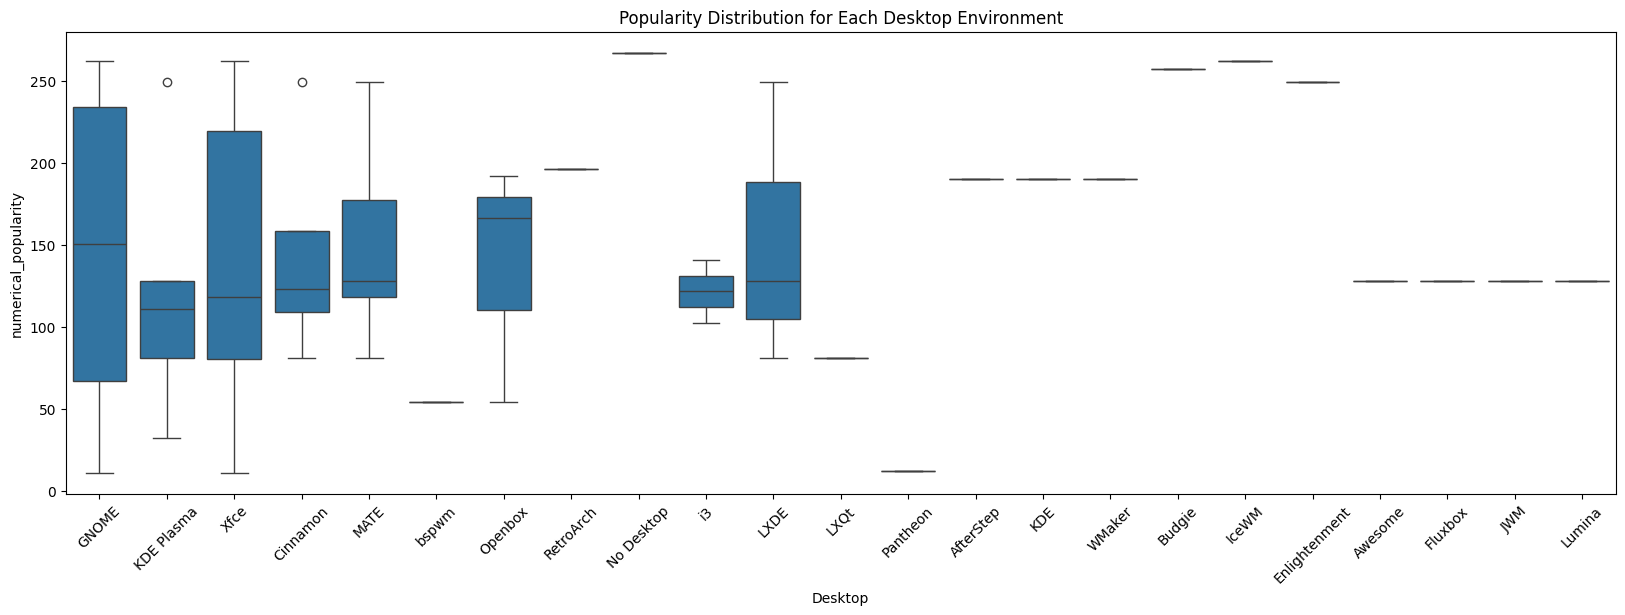

In [20]:
import seaborn as sns

plt.figure(figsize=(20, 6))
sns.boxplot(x='Desktop', y='numerical_popularity', data=df_split.head(50))
plt.title('Popularity Distribution for Each Desktop Environment')
plt.xticks(rotation=45)
plt.show()

## K-means Clustering

Using K-means clustering we can group different Linux distributions based on their OS Type, and visualize how these clusters relate to their popularity.

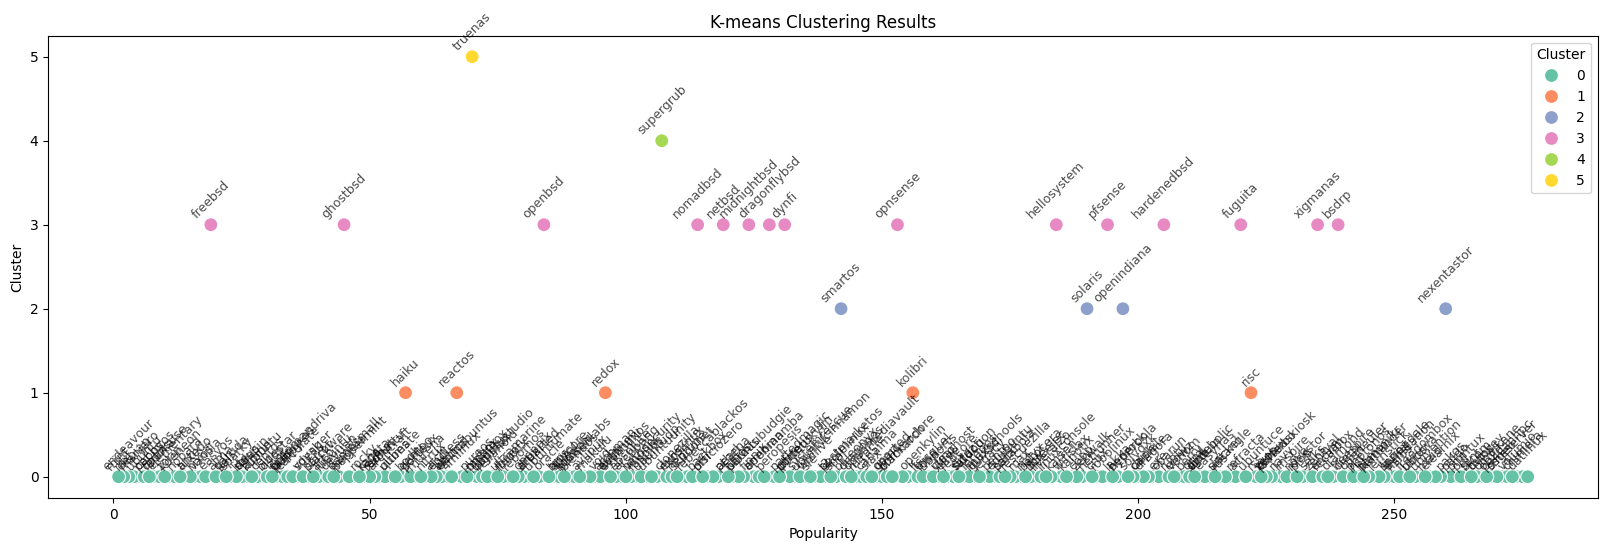

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Preprocess the data
df = df_distros[['Distro', 'numerical_popularity']].copy()
df_encoded = pd.get_dummies(df_distros['OS Type'])  # One-hot encoding categorical data
X = df_encoded

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering
kmeans = KMeans(n_clusters=6, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize the clusters
plt.figure(figsize=(20, 6))
sns.scatterplot(x=df['numerical_popularity'], y=df['Cluster'], hue=df['Cluster'], palette='Set2', s=100)

# Add OS names to the plot
for i in range(len(df)):
    plt.annotate(df['Distro'].iloc[i], (df['numerical_popularity'].iloc[i], df['Cluster'].iloc[i]),
                 textcoords="offset points", xytext=(0, 5), ha='center', fontsize=9, alpha=0.7, rotation=45)

plt.title('K-means Clustering Results')
plt.xlabel('Popularity')
plt.ylabel('Cluster')
plt.show()

## Principal Component Analysis

Here we apply PCA to reduce the dimensionality of the dataset while preserving as much variance as possible. It helps visualize the data in 2D (using the first two principal components) and also identifies the most influential features in determining the structure of the data. The scree plot helps assess how well the principal components capture the variance in the data. The loading scores reveal which features are most significant for the principal components, which can provide insights into which features contribute most to the distribution's characteristics.

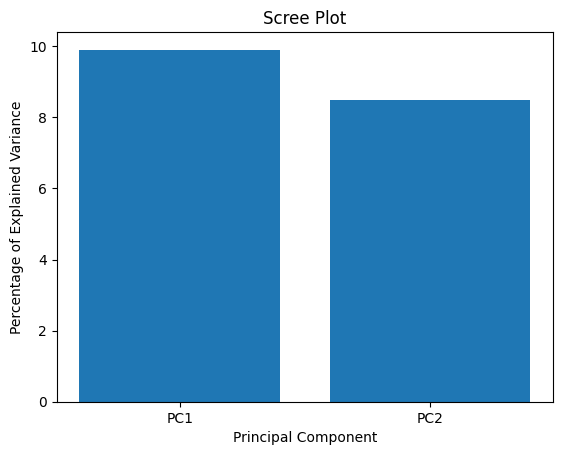

Explained Variance Ratio: [0.09873518 0.08512256]


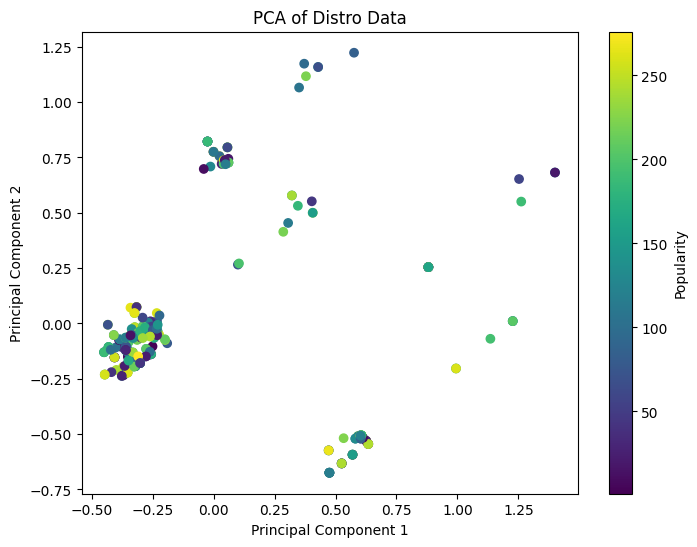

cat__Origin_USA                  0.821193
cat__OS Type_Linux              -0.320088
cat__Based On_Independent        0.285491
cat__OS Type_BSD                 0.199231
cat__Based On_Debian (Stable)   -0.123363
cat__Based On_Debian            -0.120437
cat__Based On_FreeBSD            0.112241
cat__Origin_Germany             -0.100044
cat__Origin_France              -0.084608
cat__Origin_Italy               -0.072763
dtype: float64


In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

# We'll first define which columns are categorical and numerical
categorical_columns = ['OS Type', 'Based On', 'Origin']

# Define a column transformer
# OneHotEncoding for categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns)
    ])
pca = PCA(n_components=2) # Reduce to 2 components for visualization
# Create a pipeline with preprocessor and PCA
pca_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', pca)
])

# Fit and transform the data using the pipeline
X_pca = pca_pipeline.fit_transform(df_distros)

# The following code constructs the Scree plot
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

# Explained Variance Ratio
print("Explained Variance Ratio:", pca_pipeline.named_steps['pca'].explained_variance_ratio_)

# Scatter plot for the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_distros['numerical_popularity'], cmap='viridis')
plt.colorbar(label='Popularity')
plt.title("PCA of Distro Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

loading_scores = pd.Series(pca.components_[0], index=pca_pipeline.named_steps['preprocessor'].get_feature_names_out())
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
top_10_params = sorted_loading_scores[0:10].index.values
print(loading_scores[top_10_params])

## Hierarchical Clustering

Here we apply agglomerative hierarchical clustering to group Linux distributions based on their features, including their popularity. The results are visualized both in a scatter plot (showing the cluster distribution) and in a dendrogram (showing the hierarchical relationships between the clusters).

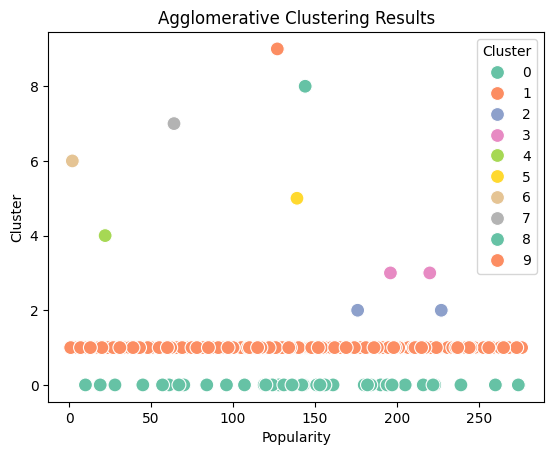

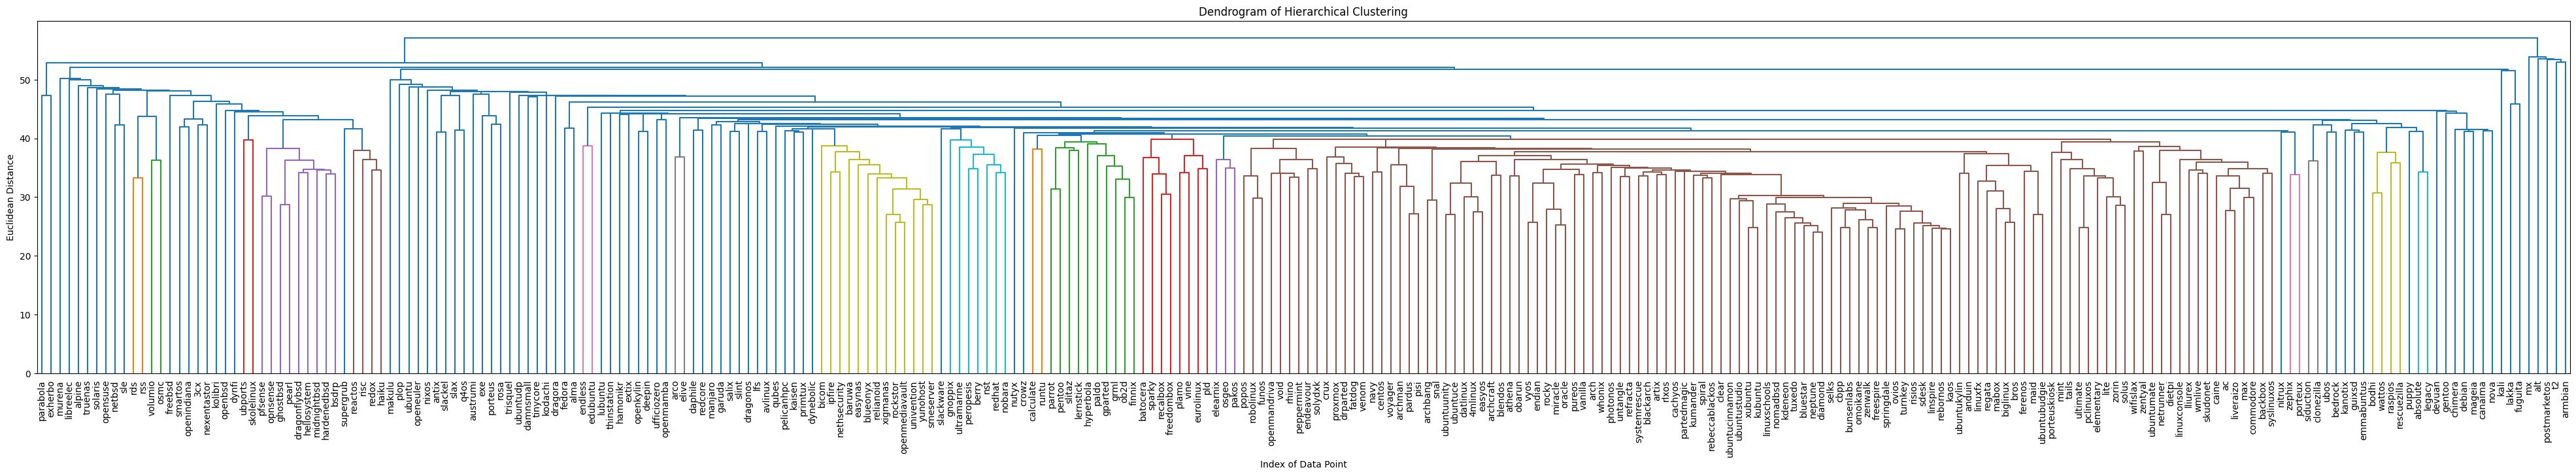

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

df = df_distros

# Preprocess the data (Standardize the numerical features)
X = pd.get_dummies(df.drop(columns=['Popularity']))  # One-hot encoding categorical data

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform Agglomerative Hierarchical Clustering
model = AgglomerativeClustering(n_clusters=10)
df['Cluster'] = model.fit_predict(X_scaled)

# Visualize the results
sns.scatterplot(x=df['numerical_popularity'], y=df['Cluster'], hue=df['Cluster'], palette='Set2', s=100)
plt.title("Agglomerative Clustering Results")
plt.xlabel('Popularity')
plt.ylabel('Cluster')
plt.show()

# Generate the Dendrogram for visualization
linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(50, 7))
dendrogram(linked, labels=df['Distro'].values, orientation='top', leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrogram of Hierarchical Clustering")
plt.xlabel("Index of Data Point")
plt.ylabel("Euclidean Distance")
plt.show()

## Random Forest Regression

Using random forest regression we can understand which categorical features (like OS Type, Architecture, etc.) have the most impact on predicting the popularity of different Linux distributions.

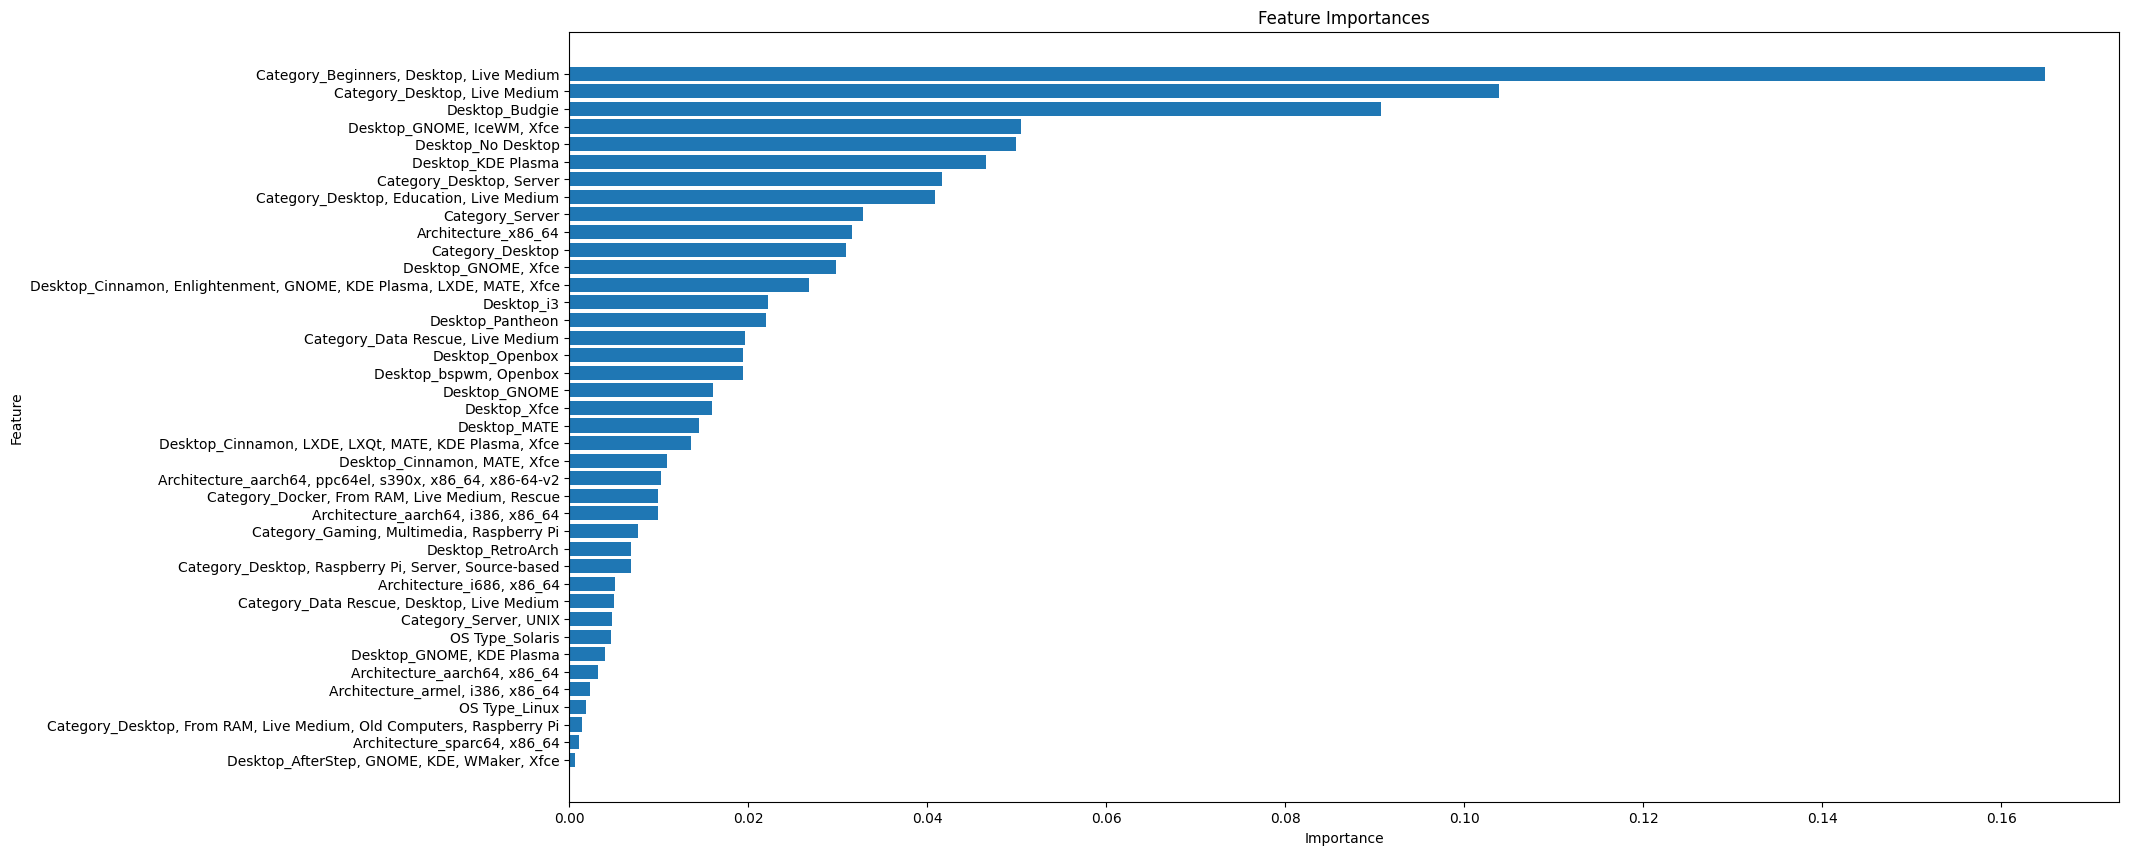

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define categorical columns
categorical_columns = ['OS Type', 'Architecture', 'Desktop', 'Category']

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns)
    ])

# Create the pipeline with preprocessor and RandomForestRegressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Fit the model
X = df_distros.head(20)
y = df_distros.head(20)['numerical_popularity']
pipeline.fit(X, y)

# Get feature importances
feature_importances = pipeline.named_steps['regressor'].feature_importances_
feature_names = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_columns).tolist()

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(20, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()